In [74]:
import sys , time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from zipfile import ZipFile
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

In [3]:
# from sklearn.linear_model import  LogisticRegression , SGDClassifier , RidgeClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier , ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier #, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lgb
# from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split ,cross_val_score , GridSearchCV
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score , precision_score , f1_score , recall_score

In [4]:
# models = {'Logistic Regression' : LogisticRegression(solver='lbfgs', max_iter=1000),
#         #   'SVM' : SVC(),
#           'Decision Tree' : DecisionTreeClassifier(),
#           'Random Forest' : RandomForestClassifier(),
#           'AdaBoost' : AdaBoostClassifier(algorithm='SAMME'),
#           'Bagging' : BaggingClassifier(),
#           'Gradient Boosting' : GradientBoostingClassifier(),
#           'Naive Bayes' : GaussianNB(),
#           'SGD' : SGDClassifier(),
#           'Ridge' : RidgeClassifier(),
#           'ExtraTrees' : ExtraTreeClassifier(),
#           'XGB' : XGBClassifier(),
#         #   'KNN' : KNeighborsClassifier(n_neighbors=5),
#         #   'LGB' : lgb
#           }

In [5]:
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

In [6]:
# from imblearn.under_sampling import RandomUnderSampler
# smt = RandomUnderSampler(random_state=42)
# X , y = smt.fit_resample(X, y)

In [7]:
pd.concat([X,y],axis=1)['Diabetes_binary'].value_counts()

Diabetes_binary
0    218334
1     35346
Name: count, dtype: int64

In [8]:
df = pd.concat([X,y],axis=1)

In [9]:
# Dropping outliers
lower_limit = np.quantile(df['BMI'], 0.25)
upper_limit = np.quantile(df['BMI'], 0.75)
outlier_index = df[(df['BMI'] < lower_limit) | (df['BMI'] > upper_limit)].index
df.drop(outlier_index, inplace=True)

In [10]:
df.shape

(140147, 22)

In [11]:
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

In [12]:
# def model_selection(model:dict, X_train, y_train, X_test, y_test):
#     """
#     Tests each model in the models dict against the training data and test data
#     and provides its accuracy score
#     :param model: dictionary of the models
#     :param X_train: Training data
#     :param y_train: Training labels
#     :param X_test: Test data
#     :param y_test: Test labels
#     :return: Accuracy score
#     """
#     a = []
#     p = []
#     f = []
#     r = []

#     for name, model in model.items():
#         model.fit(X_train, y_train.values.ravel())
#         y_pred = model.predict(X_test)
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred)
#         f1 = f1_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred)
#         a.append(accuracy) , p.append(precision) , f.append(f1) , r.append(recall)
#         print('Accuracy score for {}: {}'.format(name, accuracy))
#     names = list(models.keys())
#     results = pd.DataFrame({'Model_Name':names , 'Accuracy':a , 'Precison':p , 'F1 score': f , 'Recall':r})
#     return results.sort_values('Accuracy', ascending= False, ignore_index=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
col_trans = ColumnTransformer(transformers=[('scaler', scaler, ['BMI'])], remainder='passthrough')
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)
# results = model_selection(models, X_train, y_train, X_test, y_test)

### Cross validation

In [14]:
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.87613271, 0.87463432, 0.87680617, 0.8742374 , 0.87462985])

In [15]:
print("{} accuracy with a standard deviation of {}".format
      (scores.mean(), scores.std()))

0.8752880890004258 accuracy with a standard deviation of 0.0009982581497818704


### Hyperparameter tuning

In [16]:
param_grid = {
    'n_estimators': [50 ,100 , 200],
    'max_depth': [None, 5, 10, 20],
    "min_samples_leaf" : [1, 2, 4],
}

In [34]:
# grid_search = GridSearchCV(clf,
#                            param_grid=param_grid , cv=5, verbose=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomForestClassifier(max_depth=20, min_samples_leaf=4, random_state=42)


#### Results of Hyperparameter tuning
{'max_depth': 20, 'min_samples_leaf': 4, 'n_estimators': 100}

### Final parameters for Random Forest

In [17]:
%%timeit

clf = RandomForestClassifier(max_depth=20, min_samples_leaf=4, random_state=42)
clf.fit(X_train, y_train)


4.89 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
clf = RandomForestClassifier(max_depth=20, min_samples_leaf=4, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, random_state=42)

In [19]:
y_pred = clf.predict(X_test)
print("accuracy_score: ", accuracy_score(y_test, y_pred))
print("precision_score: ", precision_score(y_test, y_pred))
print("f1_score: ", f1_score(y_test, y_pred))
print("recall_score: ", recall_score(y_test, y_pred))

accuracy_score:  0.8814841241526935
precision_score:  0.5333333333333333
f1_score:  0.050314465408805034
recall_score:  0.026402640264026403


In [20]:
## Model Size
model_size = sys.getsizeof(clf)
print("Model size:", model_size, "bytes")

Model size: 56 bytes


In [21]:
## feaure importance
feature_names = [f"{i}" for i in X.columns]
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances[:10]

GenHlth      0.135375
Age          0.121997
HighBP       0.093090
HighChol     0.087644
Income       0.087295
PhysHlth     0.080135
MentHlth     0.055675
Education    0.054646
CholCheck    0.046335
DiffWalk     0.037663
dtype: float64

In [24]:
# Randomizing the data with X , y split
rf_results = pd.DataFrame(columns=['Accuracy', 'Precision', 'F1 Score', 'Recall', 'Model Size', 'Time'])
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i)
    scaler = StandardScaler()
    col_trans = ColumnTransformer(
        transformers=[('scaler', scaler, ['BMI'])], remainder='passthrough')
    X_train = col_trans.fit_transform(X_train)
    X_test = col_trans.transform(X_test)
    start = time.time()
    clf = RandomForestClassifier(
        max_depth=20, min_samples_leaf=4, random_state=42)
    clf.fit(X_train, y_train)
    stop = time.time()
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    model_size = sys.getsizeof(clf)
    time_taken = stop - start
    rf_results.loc[i] = [accuracy, precision, f1, recall, model_size, time_taken]
rf_results
    

Accuracy  Precision  F1 Score    Recall  Model Size      Time
0  0.881484   0.533333  0.050314  0.026403        56.0  5.040623
1  0.881484   0.557576  0.052481  0.027537        56.0  4.938305
2  0.883518   0.561290  0.050596  0.026492        56.0  4.889101
3  0.884980   0.500000  0.060058  0.031948        56.0  4.812285
4  0.880414   0.502463  0.057368  0.030421        56.0  4.852709
5  0.880057   0.512563  0.057207  0.030294        56.0  4.853313
6  0.879344   0.496815  0.044093  0.023070        56.0  5.049620
7  0.885337   0.486772  0.054149  0.028669        56.0  4.781122
8  0.882626   0.483516  0.050779  0.026797        56.0  4.851414
9  0.880628   0.544444  0.055336  0.029149        56.0  5.609555

In [86]:
rf_results.describe().T.round(5)

count      mean      std       min       25%       50%       75%  \
Accuracy     10.0   0.88199  0.00207   0.87934   0.88047   0.88148   0.88329   
Precision    10.0   0.51788  0.02903   0.48352   0.49761   0.50751   0.54167   
F1 Score     10.0   0.05324  0.00460   0.04409   0.05064   0.05332   0.05674   
Recall       10.0   0.02808  0.00256   0.02307   0.02657   0.02810   0.03001   
Model Size   10.0  56.00000  0.00000  56.00000  56.00000  56.00000  56.00000   
Time         10.0   4.96780  0.24263   4.78112   4.85174   4.87121   5.01504   

                 max  
Accuracy     0.88534  
Precision    0.56129  
F1 Score     0.06006  
Recall       0.03195  
Model Size  56.00000  
Time         5.60956

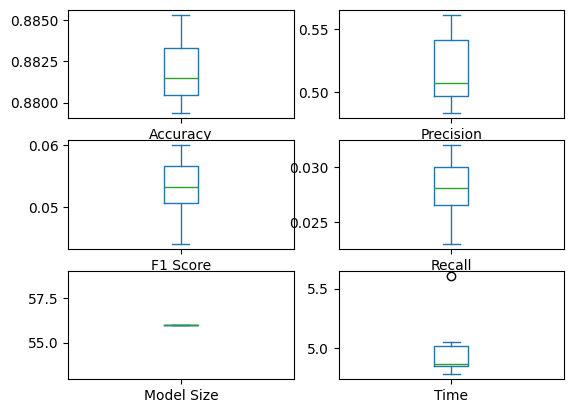

In [37]:
rf_results.plot(kind='box', subplots=True, layout=(3, 2) , sharex=False, sharey=False)
plt.show()

# YDF

In [38]:
import ydf

In [39]:
df['Diabetes_binary'] = df['Diabetes_binary'].astype('Int16')

In [40]:
train_ds , test_ds = train_test_split(df,random_state=0)

In [41]:
model = ydf.GradientBoostedTreesLearner(label='Diabetes_binary').train(train_ds)

Train model on 105110 examples
Model trained in 0:00:02.498373


In [42]:
model.describe()

In [43]:
model.evaluate(test_ds)

Evaluation()

In [44]:
model.analyze(test_ds)

## Cross Validation of YDF

In [45]:
learner = ydf.GradientBoostedTreesLearner(label='Diabetes_binary')
evaluation = learner.cross_validation(df, folds=5)

evaluation

Evaluation()

In [46]:
templates = ydf.GradientBoostedTreesLearner.hyperparameter_templates()
templates

{'better_defaultv1': HyperparameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'),
 'benchmark_rank1v1': HyperparameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')}

In [47]:
better_defaultv1 = templates["better_defaultv1"]
learner = ydf.GradientBoostedTreesLearner(
    'Diabetes_binary', **better_defaultv1).train(train_ds)

Train model on 105110 examples
Model trained in 0:00:02.958408


In [48]:
learner.evaluate(test_ds)

Evaluation()

In [49]:
benchmark_rank1v1 = templates["benchmark_rank1v1"]
learner = ydf.GradientBoostedTreesLearner(
    'Diabetes_binary', **benchmark_rank1v1).train(train_ds)
learner.evaluate(test_ds)

Train model on 105110 examples
Model trained in 0:00:05.999990


Evaluation()

### Final parameters for YDF

In [69]:
learner = ydf.GradientBoostedTreesLearner(
    'Diabetes_binary', **benchmark_rank1v1).train(train_ds)
evaluation = learner.evaluate(test_ds)

Train model on 105110 examples
Model trained in 0:00:09.333597


In [70]:
print(evaluation)

accuracy: 0.881839
confusion matrix:
    label (row) \ prediction (col)
    +-------+-------+-------+
    |       |     0 |     1 |
    +-------+-------+-------+
    |     0 | 30681 |   206 |
    +-------+-------+-------+
    |     1 |  3934 |   216 |
    +-------+-------+-------+
characteristics:
    name: '1' vs others
    ROC AUC: 0.805373
    PR AUC: 0.336002
    Num thresholds: 10000
loss: 0.297803
num examples: 35037
num examples (weighted): 35037



In [71]:
evaluation.accuracy

0.8818391985615207

In [73]:
# Precision
precision = evaluation.confusion_matrix.matrix[0][0] / (evaluation.confusion_matrix.matrix[0][0] + evaluation.confusion_matrix.matrix[0][1])
print("Precision: ", precision)
# Recall
recall = evaluation.confusion_matrix.matrix[0][0] / (evaluation.confusion_matrix.matrix[0][0] + evaluation.confusion_matrix.matrix[1][0])
print("Recall: ", recall)
# F1 Score
f1 = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1)

Precision:  0.9933305274063522
Recall:  0.8863498483316481
F1 Score:  0.9367958230283046


In [61]:
learner.describe()

In [66]:
sys.getsizeof(learner)

56

In [67]:
# Randomizing the data with X , y split
gb_results = pd.DataFrame(columns=['Accuracy', 'Precision', 'F1 Score', 'Recall', 'Model Size', 'Time'])
for i in range(10):
    train_ds, test_ds = train_test_split(df, random_state=i)
    benchmark_rank1v1 = templates["benchmark_rank1v1"]
    start = time.time()
    learner = ydf.GradientBoostedTreesLearner(
        'Diabetes_binary', **benchmark_rank1v1).train(train_ds)
    stop = time.time()
    evaluation = learner.evaluate(test_ds)
    accuracy = evaluation.accuracy
    precision = evaluation.confusion_matrix.matrix[0][0] / (
        evaluation.confusion_matrix.matrix[0][0] + evaluation.confusion_matrix.matrix[0][1])
    recall = evaluation.confusion_matrix.matrix[0][0] / (
        evaluation.confusion_matrix.matrix[0][0] + evaluation.confusion_matrix.matrix[1][0])
    f1 = 2 * (precision * recall) / (precision + recall)
    model_size = sys.getsizeof(learner)
    time_taken = stop - start
    gb_results.loc[i] = [accuracy, precision, f1, recall, model_size, time_taken]
gb_results

Train model on 105110 examples
Model trained in 0:00:05.923095
Train model on 105110 examples
Model trained in 0:00:08.231475
Train model on 105110 examples
Model trained in 0:00:06.729176
Train model on 105110 examples
Model trained in 0:00:07.855705
Train model on 105110 examples
Model trained in 0:00:14.752498
Train model on 105110 examples
Model trained in 0:00:11.958791
Train model on 105110 examples
Model trained in 0:00:33.248901
Train model on 105110 examples
Model trained in 0:00:11.138727
Train model on 105110 examples
Model trained in 0:00:07.167337
Train model on 105110 examples
Model trained in 0:00:09.802882


Accuracy  Precision  F1 Score    Recall  Model Size       Time
0  0.882838   0.996438  0.937472  0.885095        56.0   5.950940
1  0.880555   0.994875  0.936139  0.883951        56.0   8.268454
2  0.884379   0.994669  0.938270  0.887924        56.0   6.761293
3  0.883923   0.993669  0.937996  0.888231        56.0   7.884521
4  0.879213   0.992701  0.935328  0.884224        56.0  14.787836
5  0.880612   0.993484  0.936117  0.885013        56.0  11.997255
6  0.881554   0.995332  0.936703  0.884597        56.0  33.321762
7  0.885093   0.993458  0.938703  0.889668        56.0  11.159113
8  0.881925   0.994467  0.936947  0.885716        56.0   7.216581
9  0.881839   0.993331  0.936796  0.886350        56.0   9.823912

In [87]:
gb_results.describe().T.round(5)

count      mean      std       min       25%       50%       75%  \
Accuracy     10.0   0.88219  0.00186   0.87921   0.88085   0.88188   0.88365   
Precision    10.0   0.99424  0.00112   0.99270   0.99346   0.99407   0.99482   
F1 Score     10.0   0.93705  0.00106   0.93533   0.93628   0.93687   0.93787   
Recall       10.0   0.88608  0.00193   0.88395   0.88470   0.88541   0.88753   
Model Size   10.0  56.00000  0.00000  56.00000  56.00000  56.00000  56.00000   
Time         10.0  11.71717  8.06095   5.95094   7.38357   9.04618  11.78772   

                 max  
Accuracy     0.88509  
Precision    0.99644  
F1 Score     0.93870  
Recall       0.88967  
Model Size  56.00000  
Time        33.32176

In [84]:
## Significance Testing with Pingouin
for i in rf_results.columns:
    print(i)
    print(stats.ttest_ind(rf_results[i], gb_results[i]))
    print("=="*50)

Accuracy
TtestResult(statistic=-0.23396495556032085, pvalue=0.8176525728315747, df=18.0)
Precision
TtestResult(statistic=-51.85938429255839, pvalue=4.7213391174950035e-21, df=18.0)
F1 Score
TtestResult(statistic=-592.14387590922, pvalue=4.590358517100128e-40, df=18.0)
Recall
TtestResult(statistic=-845.8688413698204, pvalue=7.484790863717256e-43, df=18.0)
Model Size
TtestResult(statistic=nan, pvalue=nan, df=18.0)
Time
TtestResult(statistic=-2.6465490001116354, pvalue=0.016408091752808836, df=18.0)
